In [1]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from potosnail import Evaluater
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

df = pd.read_csv(r'C:\Users\aacjp\Sales-Scientist\datasets\leadsML.csv').drop(['Unnamed: 0'], axis='columns')
w = pd.read_csv(r'C:\Users\aacjp\Sales-Scientist\datasets\check6.csv').drop(['Unnamed: 0'], axis='columns')

In [2]:
domains = ['apparel',
 'ecommerce',
 'entrepreneurship',
 'film',
 'finance',
 'fitness',
 'health',
 'marketing',
 'nutrition',
 'photography',
 'productivity',
 'realestate',
 'self-development',
 'skincare',
 'technology']
models = ['consulting', 'ecommerce', 'info', 'media', 'software']
platforms = ['Youtube',
 'facebook',
 'instagram',
 'linkedin',
 'other',
 'pinterest',
 'quora',
 'reddit',
 'youtube']

# Model 1: simple bayesian infrence from scratch

This model is very simple. It only takes the revenue and niche (business model and domain combination) into account. It is build under Bayes Theorem of P(A|B) = P(B|A) * P(A) / P(B)

In [3]:
def bayesianInfrence(df, revenue, domain, business_model, margin=0.1):
    '''finds the probability that a lead will convert given it's revenue and niche'''
    greater = df.loc[df['revenue']>revenue-(revenue*margin)]
    inrange = greater.loc[greater['revenue']<revenue+(revenue*margin)]
    domain = inrange.loc[inrange[domain]==1]
    model = domain.loc[inrange[business_model]==1]
    if len(model) != 0:
        closed = model.loc[model['customer']==1]
        return len(closed) / len(model) #*10
    else:
        return 'Sorry, not enough data available'

bayesianInfrence(df, 500000, 'software', 'ecommerce', margin=0.5)

0.5

In [4]:
def scoreBI(df, model=None, old_df=w, margin=0.1):
    '''scores the bayesian infrence model'''
    correct = 0
    sse = 0
    counter = 0
    for i in range(len(df)):
        domain = old_df.iloc[i]['domain']
        model = old_df.iloc[i]['model']
        revenue = df.iloc[i]['revenue']
        actual = df.iloc[i]['customer']
        result = bayesianInfrence(df, revenue, domain, model, margin=margin)
        try:
            output = int(round(result))
            sse += abs(actual-result)
            counter += 1
            if output == actual:
                correct += 1
        except:
            pass
    accuracy = correct / len(df)
    rmse = sse / counter
    print('relative accuracy: {}'.format(correct/counter))    
    return ('Score: {}, Error: {}'.format(accuracy, rmse)), counter, correct

In [5]:
print('validation: {}'.format(scoreBI(df)))

relative accuracy: 0.9038461538461539
validation: ('Score: 0.7966101694915254, Error: 0.10256410256410256', 52, 47)


# model 2

In this model I combine probability of closing with average twitter polarity to score each lead. The reason for this is that twitter polarity (positive or negative) has a positive association with return on adspend (ROAS). This matters because businesses with negative polarity on twitter are less likley to have a good return on adspend and therefore less likley to reap the benefits of Hyros.  

In [6]:
def scoreLeads(df, old_df=w, margin=0.1):
    '''scores leads based on revenue, niche, and twitter sentiment'''
    scores = []
    for i in range(len(df)):
        # scoring leads
        domain = old_df.iloc[i]['domain']
        model = old_df.iloc[i]['model']
        revenue = df.iloc[i]['revenue']
        sentiment = (df.iloc[i]['avg_polarity']+1)/2
        result = bayesianInfrence(df, revenue, domain, model, margin=margin)
        try:
            score = round(result)*5 + round(sentiment*5, 1)
        except: 
            score = round(sentiment*10, 1)
        scores.append(score)
    leads = list(old_df['name'])
    return pd.DataFrame({'lead': leads, 'score': scores})

I put the scores on a scale of 1-10

In [7]:
print('validation results...')
scoreLeads(df)

validation results...


,lead,score
0,clickfunnels.com,8.0
1,kinobody.com,7.7
2,FrankKern.com,7.5
3,ImpactTheory.Com,8.2
4,digitalmillionairesecrets.com,8.4
5,mastermind.com,7.3
6,ShopaNova.com,2.5
7,SamCart.io,7.7
8,billygeneismarketing.com,2.8
9,Ladyboss.com,7.6


**Things to try**

* bayesian infrence 
* 50% bayesian infrence, 50% twitter sentiment
* 50% bayesian infrence, 25% twitter sentiment, 25% adspend leak. Build a regression model that predicts adspend leaks
* test sklearn models
* try data augmentation
* create a custom version of the best sklearn model

# Model 3: combining bayesian infrence for probability, with twitter sentiment and adspend leaks regression model for quality

**opportunity score**
opportunity score takes adspend, cac (cost of aquisition), and twitter sentiment into account.This is because when all 3 of these are high there is a good opportunity with the lead because it means they are spending a lot on ads and are well recieved by the public this is good because it indicates that they have a good product/service and that Hyros can save them a lot of money on advertising.

## include formulas!

**probability score**
probability score represents the predicted probability that a given lead will convert to a customer. it takes revenue, business model, domain, and business model into account.

In [8]:
def leadScoringModel(df, old_df=w, margin=0.1, prob_weight=5):
    inv = 10-prob_weight
    scores = []
    mu_cac = np.mean(df['cac'])
    mu_adspend = np.mean(df['adspend'])
    s_cac = np.std(df['cac'])
    s_adspend = np.std(df['adspend'])
    for i in range(len(df)):
        sample = df.iloc[i]
        cac_z = (sample['cac'] - mu_cac)/s_cac
        adspend_z = (sample['adspend'] - mu_adspend)/s_adspend
        if sample['adspend'] < 15000:
            oportunity_score = 0
        sentiment = sample['avg_polarity']
        domain = old_df.iloc[i]['domain']
        model = old_df.iloc[i]['model']
        revenue = sample['revenue']
        predicted = bayesianInfrence(df, revenue, domain, model, margin=margin)
        opportunity_score = round(round(((cac_z+3)+(adspend_z+3)+(sentiment+1))/14, 2)*inv, 1)
        try:
            probability_score = round(predicted*prob_weight, 1)
        except: 
            probability_score = 2.5
        score = opportunity_score + probability_score
        scores.append(score)
    return pd.DataFrame({'lead': list(old_df['name']), 'score': scores})

In [9]:
results = leadScoringModel(df)
results

,lead,score
0,clickfunnels.com,7.3
1,kinobody.com,7.4
2,FrankKern.com,7.4
3,ImpactTheory.Com,7.4
4,digitalmillionairesecrets.com,7.4
5,mastermind.com,7.3
6,ShopaNova.com,5.1
7,SamCart.io,7.3
8,billygeneismarketing.com,4.8
9,Ladyboss.com,7.7


In [10]:
def evaluate(results, df, quiet=True):
    results['actual'] = df['customer']
    correct = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(results)):
        if int(round(results['score'][i]/10)) == df['customer'][i]:
            correct += 1
            if df['customer'][i] == 1:
                tp += 1
            if df['customer'][i] == 0:
                tn += 1
        else:
            if df['customer'][i] == 1:
                fn += 1
            if df['customer'][i] == 0:
                fp += 1
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    accuracy = correct/len(results)
    if quiet == False:
        cm = np.array([[tp, fp], [fn, tn]])
        print(sns.heatmap(cm, annot=True, cmap='Blues'))
    return ('accuracy: {}, precision: {}, recall: {}'.format(accuracy, precision, recall), cm)

AxesSubplot(0.125,0.125;0.62x0.755)
validation results...


'accuracy: 0.8813559322033898, precision: 0.9259259259259259, recall: 0.8333333333333334'

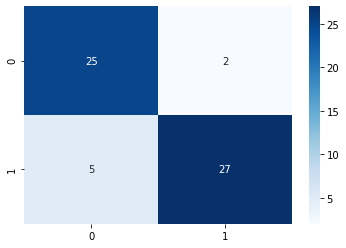

In [11]:
evaluation, cm= evaluate(results, df, quiet=False)
print('validation results...')
evaluation

In [12]:
def cba(cm, action, value):
    guess = int(round((sum(cm[0])+sum(cm[1]))/4))
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    cost = action*tp + action*fp + value*fn
    benefit = (tp-guess)*value + action*fn + action*tn
    return cost, benefit

def cbaHyros(cm, upfront=5000, monthly=1000, action=100, quiet=False):
    upfront_cost, upfront_benefit = cba(cm, action, upfront)
    monthly_cost, monthly_benefit = cba(cm, 0, monthly)
    if quiet==False:
        return '''cost: ${} upfront and ${} each month going forward. benefit: ${} upfront and ${} each month going forward.'''.format(upfront_cost, monthly_cost, upfront_benefit, monthly_benefit)
    else:
        return upfront_cost, monthly_cost, upfront_benefit, monthly_benefit

cbaHyros(cm)

'cost: $27700 upfront and $5000 each month going forward. benefit: $53200 upfront and $10000 each month going forward.'

## stuff to try

4. sklearn models; off the shelf, include number of sales, feature importance, scaling
5. pure sklearn models
6. best classifier from scratch
7. research paper implementation

# Taking Sales into account

After exchanging messages on LinkedIn with a sales rep at a competing company, that's also an ad tracking software, I found out that the number of sales a prospect makes each month is an important factor when assesing a prospect. For this reason I have decided to look into monthly sales within my dataset. In the plot below I compared the distributions of monthly sales between customers and non-customers and saw that customers have less variance in sales than non-customers. For this reason I will measure sales by taking the absolute z-score of the monthly sales for each lead rather than the actual number. That way higher values will alaways be associated with non-customers and vice versa.

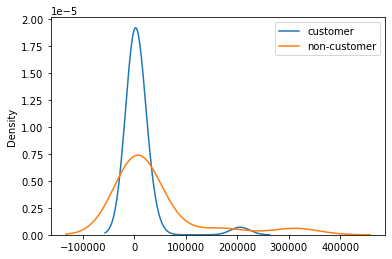

In [13]:
customers = list(df.loc[df['customer']==1]['sales'])
non_customers = list(df.loc[df['customer']==0]['sales'])
sns.kdeplot(x=customers, label='customer')
sns.kdeplot(x=non_customers, label='non-customer')
plt.legend()
plt.show()

In [14]:
mu_sales = np.mean(df['sales'])
sigma_sales = np.std(df['sales'])
df['salesScore'] = df['sales'].apply(lambda x: abs((x-mu_sales)/sigma_sales))

## a small problem

Our dataset is very small even adding one more condition, sales score, would create a situation where the model wouldn't have enough data to make predictions. for this reason I will try using the GaussianNB model from sklearn to predict the probabilities instead of my bayesian infrence model.

In [15]:
important = ['revenue', 'salesScore']
selected = important+domains+models+platforms
X = df[selected]
y = df['customer']
X.shape, y.shape

((59, 31), (59,))

In [16]:
model = GaussianNB().fit(X, y)
model.score(X, y)

0.5423728813559322

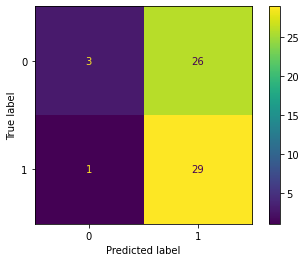

In [17]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X, y)

Looks pretty bad, however I will combine these outputs with the opportunity score and see what happens.

In [18]:
def leadScoringModel2(model, x, y, old_df=w, margin=0.1, prob_weight=5):
    model.fit(x, y)
    predicted = model.predict(x)
    inv = 10-prob_weight
    scores = []
    mu_cac = np.mean(df['cac'])
    mu_adspend = np.mean(df['adspend'])
    s_cac = np.std(df['cac'])
    s_adspend = np.std(df['adspend'])
    for i in range(len(x)):
        sample = old_df.iloc[i]
        cac_z = (sample['cac'] - mu_cac)/s_cac
        adspend_z = (sample['adspend'] - mu_adspend)/s_adspend
        if sample['adspend'] < 15000:
            oportunity_score = 0
        sentiment = sample['avg_polarity']
        opportunity_score = round(round(((cac_z+3)+(adspend_z+3)+(sentiment+1))/14, 2)*inv, 1)
        probability_score = round(predicted[i]*prob_weight, 1)
        score = opportunity_score + probability_score
        scores.append(score)
    return pd.DataFrame({'lead': list(old_df['name']), 'score': scores})

In [19]:
results_nb = leadScoringModel2(model, X, y)
results_nb

,lead,score
0,clickfunnels.com,7.3
1,kinobody.com,7.4
2,FrankKern.com,7.4
3,ImpactTheory.Com,7.4
4,digitalmillionairesecrets.com,7.4
5,mastermind.com,7.3
6,ShopaNova.com,7.6
7,SamCart.io,7.3
8,billygeneismarketing.com,7.3
9,Ladyboss.com,7.7


AxesSubplot(0.125,0.125;0.62x0.755)
accuracy: 0.5423728813559322, precision: 0.5272727272727272, recall: 0.9666666666666667


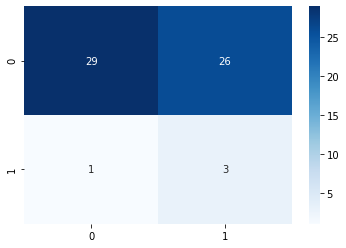

In [20]:
_, cm3 = evaluate(results_nb, df, quiet=False)
print(_)

In [21]:
cbaHyros(cm3, 15) #[tp, fp], [fn, tn]

'cost: $5515 upfront and $1000 each month going forward. benefit: $610 upfront and $14000 each month going forward.'

The model is good at identifying true positives but sucks at identifying true negatives when combined with opportunity score. The model has the poopsite problem by itself, sucks at identifying true positives.

## trying a naive bayes model with all 56 or so features

I don't think blindly feeding all the data into a model is the way to go. That being said I am still very curious to see what would happen if I did.

In [22]:
def rapidTesting(model, df, target, old_df=w, margin=0.1, prob_weight=5, guess=15):
    x = df.drop([target], axis='columns')
    y = df[target]
    results = leadScoringModel2(model, x, y, old_df, margin, prob_weight)
    _, cm = evaluate(results, df, quiet=False)
    print(_, cm)
    print(cbaHyros(cm))
    return results

AxesSubplot(0.125,0.125;0.62x0.755)
accuracy: 0.6101694915254238, precision: 0.5686274509803921, recall: 0.9666666666666667 [[29 22]
 [ 1  7]]
cost: $10100 upfront and $1000 each month going forward. benefit: $70800 upfront and $14000 each month going forward.


,lead,score,actual
0,clickfunnels.com,2.3,1
1,kinobody.com,7.4,1
2,FrankKern.com,7.4,1
3,ImpactTheory.Com,7.4,1
4,digitalmillionairesecrets.com,7.4,1
5,mastermind.com,7.3,1
6,ShopaNova.com,7.6,1
7,SamCart.io,7.3,1
8,billygeneismarketing.com,7.3,1
9,Ladyboss.com,7.7,1


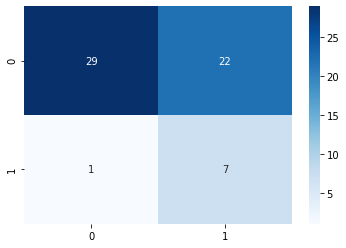

In [23]:
rapidTesting(GaussianNB(), df, 'customer')

## testing other models

AxesSubplot(0.125,0.125;0.62x0.755)
accuracy: 1.0, precision: 1.0, recall: 1.0 [[30  0]
 [ 0 29]]
cost: $3000 upfront and $0 each month going forward. benefit: $77900 upfront and $15000 each month going forward.


,lead,score,actual
0,clickfunnels.com,7.3,1
1,kinobody.com,7.4,1
2,FrankKern.com,7.4,1
3,ImpactTheory.Com,7.4,1
4,digitalmillionairesecrets.com,7.4,1
5,mastermind.com,7.3,1
6,ShopaNova.com,7.6,1
7,SamCart.io,7.3,1
8,billygeneismarketing.com,7.3,1
9,Ladyboss.com,7.7,1


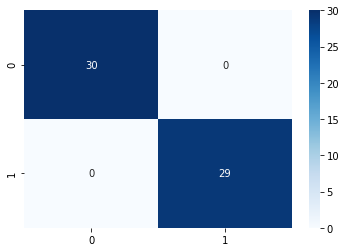

In [24]:
rapidTesting(DecisionTreeClassifier(), df, 'customer')

The DecisionTreeClassifier in combination with the opportunity score algorithm has 100% accuracy all around and the best cost benefit analysis. If in place, the model would cost ~3k worth of extra labor on the sales team's end but result in an extra 15 customers at 15k in additional monthly revenue, in addition to earning an extra 75k upfront from onboarding fees!

## Moving Forward

We have 100% accuracy with the current model and there is currently no need to improve the model. That being said, this model works well on a very small dataset with a 50% conversion rate. 

current dataset: 60 leads, 30 convert
real dataset: ~1000 leads, ~300 convert

I suspect that with the real data and a proper training/validation split the model would break! for this reason I will experiment with two more models. First I will see if there's a proven lead scoring algorithm and tailor it to my use case, it probably won't do well with the tiny dataset but will be good to have in my back pocket if the dataset grows to a few hundred samples, Second I will do a proper training/validation split with the tiny dataset and try to implement some sort of One Shot Learning, an ML technique used for making predictions based on tiny datasets.

I found a paper from Åbo Akademi University about an implementation of lead scoring with machine learning https://scholarspace.manoa.hawaii.edu/bitstream/10125/63916/0143.pdf



https://www.sciencedirect.com/science/article/abs/pii/S0167923603000204

## actions to take

0. create actions column for the output table
1. filter features by correlation to output
2. add opportunity score as a feature
3. test between models
4. try the genetic algorithm & neural net combo by Pii

## Lead scoring paper implementation

In the paper they had 200 features to choose from including the dates of actions that leads in the dataset took. We don't have that, however we will take actions similar to theirs. 

## Step 1: filter features based on correlation to the output

In [25]:
corrs = dict(df.corr()['customer'])
drop = ['customer']
for corr in corrs:
    if abs(corrs[corr]) < 0.1: #filtering out anything with a correlation of less than 10%, negative or positive, 
        drop.append(corr)
        
y2 = df['customer']
X2 = df.drop(drop, axis='columns') 

In [26]:
#what is getting dropped?
drop

['customer',
 'revenue',
 'monthlyVisitsChange',
 'adRevenue',
 'cac',
 'profit',
 'profitMargin',
 'averageOrderValue',
 'apparel',
 'fitness',
 'media',
 'software',
 'youtube']

From a business perspective I am very disturbed by the fact that revenue, cac, and profit is getting dropped. This dosen't seem like a good idea. However this is just a fun experiment...

I will also point out that this method was meant for B2C use cases while we this project is a B2B use case.

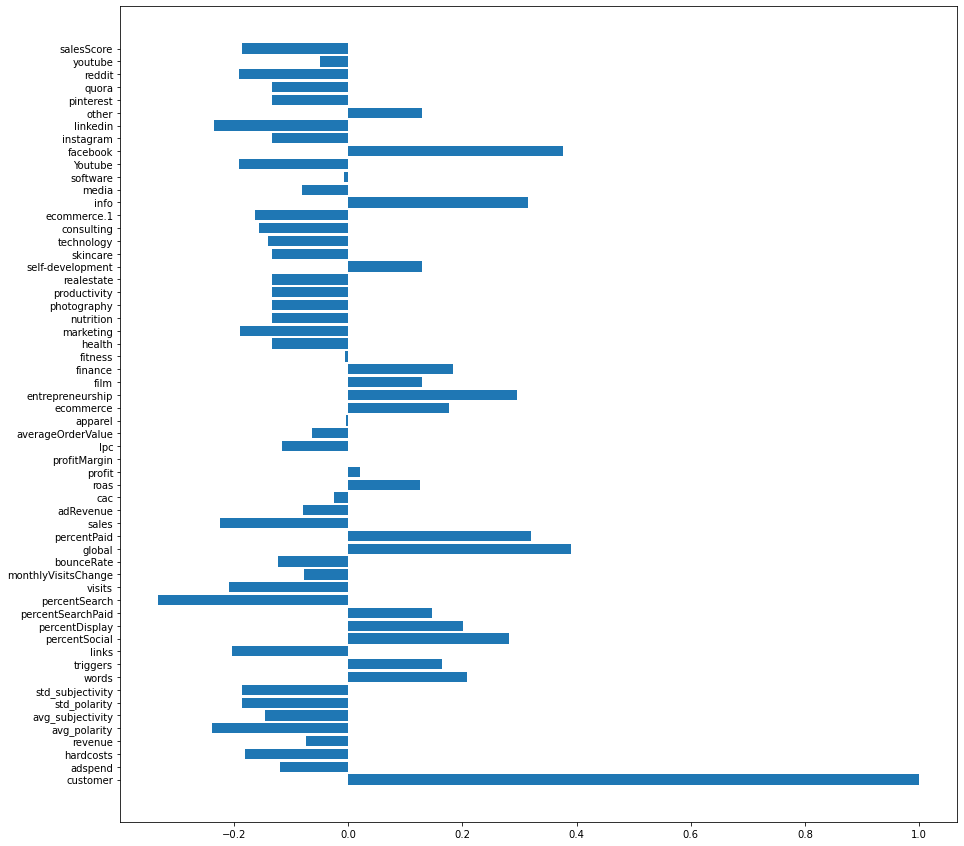

In [27]:
plt.subplots(figsize=(15,15))
plt.barh(list(corrs.keys()), list(corrs.values()))
plt.show()

## Step 2

1. compare Logistic Regression, Decision Tree, Random Forest, and MLP Neural Network against eachother.
2. compare filtered dataset by itself against filtered dataset with opportunity score as a feature against an aggregation of the filtered dataset probability with the opportunity score

going into this I expect the Random Forest trained on the filtered dataset in aggregation with the opportunity score will produce the best results.

In [34]:
def offShelf(model, X, y, cmap='Blues'):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    cm = confusion_matrix(y_test, predicted)
    print(sns.heatmap(cm, cmap=cmap, annot=True))
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    cm = np.array([[tp, fp], [fn, tn]])
    cu, cmo, bu, bm = cbaHyros(cm, quiet=True)
    print(cbaHyros(cm))
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    recall = tp / (tp+fp)
    precision = tp / (tp+fn)
    return {'net_upfront': bu-cu, 'net_monthly': bm-cmo, 'train': train_acc, 'test': test_acc, 
           'recall': recall, 'precision': precision}

def opportunityScore(df):
    scores = []
    mu_cac = np.mean(df['cac'])
    mu_adspend = np.mean(df['adspend'])
    s_cac = np.std(df['cac'])
    s_adspend = np.std(df['adspend'])
    for i in range(len(df)):
        sample = df.iloc[i]
        cac_z = (sample['cac'] - mu_cac)/s_cac
        adspend_z = (sample['adspend'] - mu_adspend)/s_adspend
        if sample['adspend'] < 15000:
            oportunity_score = 0
        sentiment = sample['avg_polarity']
        opportunity_score = round(((cac_z+3)+(adspend_z+3)+(sentiment+1))/14, 2)
        scores.append(opportunity_score)
    return scores
        
def aggregatePredictions(model, X, y, cmap='cmap'):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    opp = list(X_test['opportunity'])
    X_train = X_train.drop(['opportunity'], axis='columns')
    X_test = X_test.drop(['opportunity'], axis='columns')
    model.fit(X_train, y_train)
    predictions = list(model.predict(X_test))
    probas = list(model.predict_proba(X_test))
    prob_train_acc = model.score(X_train, y_train)
    prob_test_acc = model.score(X_test, y_test)
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    correct = 0
    y_test = list(y_test)
    for i in range(len(y_test)):
        score = (opp[i]+probas[i][0])/2
        if int(round(score)) == y_test[i]:
            correct += 1
            if y_test[i] == 1:
                tp += 1
            else:
                tn += 1
        if int(round(score)) != y_test[i]:
            if y_test[i] == 1:
                fn += 1
            else:
                fp += 1
    cm = np.array([[tp, fp], [fn, tn]])
    print(sns.heatmap(cm, annot=True, cmap='Blues'))
    cu, cmo, bu, bm = cbaHyros(cm, quiet=True)
    print(cbaHyros(cm))
    test_acc = correct/len(y_test)
    recall = tp / (tp+fp)
    precision = tp / (tp+fn)
    return {'net_upfront': bu-cu, 'net_monthly': bm-cmo, 'test accuracy': test_acc, 'recall': recall, 
            'precision': precision, 'prob_train_acc': prob_train_acc, 'prob_test_acc': prob_test_acc}

comparing models against eachother with the filtered dataset 

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $1000 upfront and $0 each month going forward. benefit: $10500 upfront and $2000 each month going forward.


{'net_upfront': 9500,
 'net_monthly': 2000,
 'train': 0.7045454545454546,
 'test': 0.7333333333333333,
 'recall': 0.6,
 'precision': 1.0}

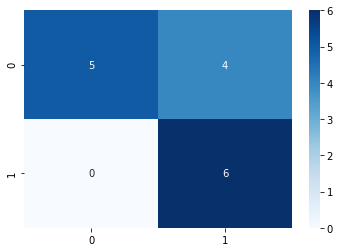

In [35]:
LR1 = offShelf(LogisticRegression(), X2, y2)
LR1

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $6000 upfront and $1000 each month going forward. benefit: $20500 upfront and $4000 each month going forward.


{'net_upfront': 14500,
 'net_monthly': 3000,
 'train': 1.0,
 'test': 0.8,
 'recall': 0.8,
 'precision': 0.8888888888888888}

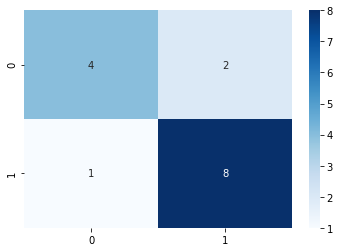

In [36]:
DT1 = offShelf(DecisionTreeClassifier(), X2, y2)
DT1

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $1000 upfront and $0 each month going forward. benefit: $25500 upfront and $5000 each month going forward.


{'net_upfront': 24500,
 'net_monthly': 5000,
 'train': 1.0,
 'test': 0.9333333333333333,
 'recall': 0.9,
 'precision': 1.0}

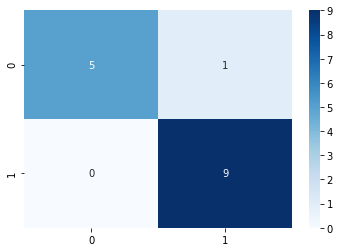

In [37]:
RF1 = offShelf(RandomForestClassifier(), X2, y2)
RF1

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $1100 upfront and $0 each month going forward. benefit: $15400 upfront and $3000 each month going forward.


{'net_upfront': 14300,
 'net_monthly': 3000,
 'train': 0.6818181818181818,
 'test': 0.7333333333333333,
 'recall': 0.6363636363636364,
 'precision': 1.0}

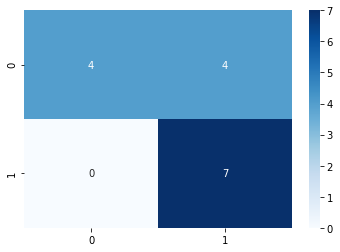

In [39]:
NN1 = offShelf(MLPClassifier(), X2, y2)
NN1

In this experiment our Random Forest did the best and got 90%+ accuracy accross the board, I consider this one to be the best so far. while the Decision Tree aggregated with the opportunity score did equally well it must be noted that there was no validation set, wheras in this one there was.

# using opportunity score as a feature

In [44]:
X3 = X2
X3['opportunity'] = opportunityScore(df)
X3.shape

(59, 46)

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $15900 upfront and $3000 each month going forward. benefit: $600 upfront and $0 each month going forward.


{'net_upfront': -15300,
 'net_monthly': -3000,
 'train': 0.7727272727272727,
 'test': 0.4666666666666667,
 'recall': 0.4444444444444444,
 'precision': 0.5714285714285714}

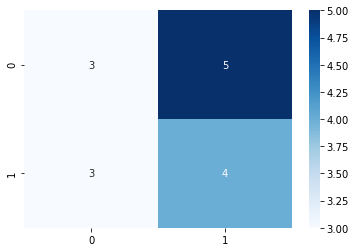

In [45]:
LR2 = offShelf(LogisticRegression(), X3, y2)
LR2

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $10800 upfront and $2000 each month going forward. benefit: $5700 upfront and $1000 each month going forward.


{'net_upfront': -5100,
 'net_monthly': -1000,
 'train': 1.0,
 'test': 0.6666666666666666,
 'recall': 0.625,
 'precision': 0.7142857142857143}

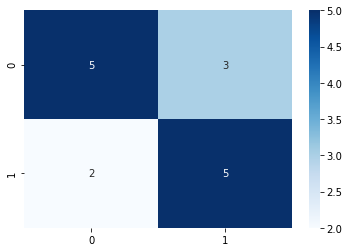

In [46]:
DT2 = offShelf(DecisionTreeClassifier(), X3, y2)
DT2

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $15700 upfront and $3000 each month going forward. benefit: $10800 upfront and $2000 each month going forward.


{'net_upfront': -4900,
 'net_monthly': -1000,
 'train': 1.0,
 'test': 0.7333333333333333,
 'recall': 0.8571428571428571,
 'precision': 0.6666666666666666}

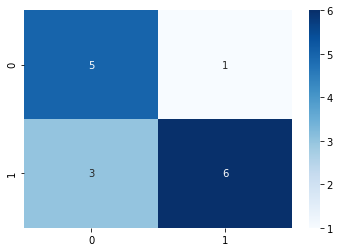

In [47]:
RF2 = offShelf(RandomForestClassifier(), X3, y2)
RF2

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $25300 upfront and $5000 each month going forward. benefit: $-3800 upfront and $-1000 each month going forward.


{'net_upfront': -29100,
 'net_monthly': -6000,
 'train': 0.5,
 'test': 0.6666666666666666,
 'recall': 1.0,
 'precision': 0.375}

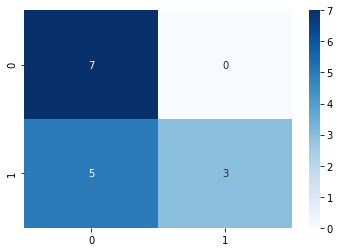

In [48]:
NN2 = offShelf(MLPClassifier(), X3, y2)
NN2

I'm suprised to see that the results aren't as good! The random forest did the best and can deliver equally good results in the long term, however it did have some false positives.

Now I'm going to see what happens when I aggregate the model outputs with the opportunity scores

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $45200 upfront and $9000 each month going forward. benefit: $-18700 upfront and $-4000 each month going forward.


{'net_upfront': -63900,
 'net_monthly': -13000,
 'test accuracy': 0.26666666666666666,
 'recall': 0.0,
 'precision': 0.0,
 'prob_train_acc': 0.6818181818181818,
 'prob_test_acc': 0.6}

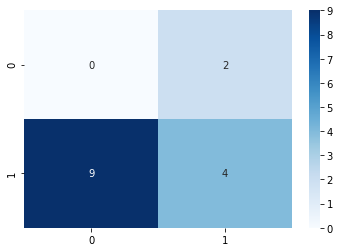

In [49]:
LR3 = aggregatePredictions(LogisticRegression(), X3, y2)
LR3

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $45600 upfront and $9000 each month going forward. benefit: $-9100 upfront and $-2000 each month going forward.


{'net_upfront': -54700,
 'net_monthly': -11000,
 'test accuracy': 0.13333333333333333,
 'recall': 0.3333333333333333,
 'precision': 0.18181818181818182,
 'prob_train_acc': 1.0,
 'prob_test_acc': 0.8666666666666667}

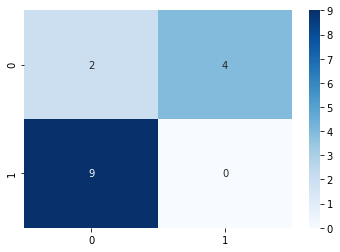

In [50]:
DT3 = aggregatePredictions(DecisionTreeClassifier(), X3, y2)
DT3

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $25900 upfront and $5000 each month going forward. benefit: $-4400 upfront and $-1000 each month going forward.


{'net_upfront': -30300,
 'net_monthly': -6000,
 'test accuracy': 0.26666666666666666,
 'recall': 0.3333333333333333,
 'precision': 0.375,
 'prob_train_acc': 1.0,
 'prob_test_acc': 0.7333333333333333}

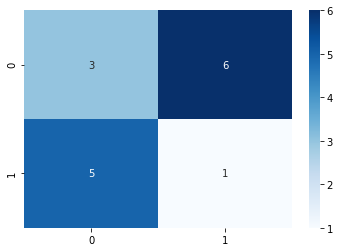

In [51]:
RF3 = aggregatePredictions(RandomForestClassifier(), X3, y2)
RF3

AxesSubplot(0.125,0.125;0.62x0.755)
cost: $30500 upfront and $6000 each month going forward. benefit: $-9000 upfront and $-2000 each month going forward.


{'net_upfront': -39500,
 'net_monthly': -8000,
 'test accuracy': 0.4,
 'recall': 0.4,
 'precision': 0.25,
 'prob_train_acc': 0.75,
 'prob_test_acc': 0.6}

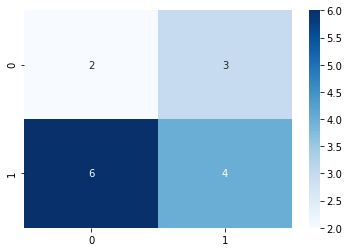

In [52]:
NN3 = aggregatePredictions(MLPClassifier(), X3, y2)
NN3

The lead scoring is really bad when I aggregate classification models with the opportunity Score. Intuitivley it makes sense, but in practice it dosen't work out so well. This raises the question; is my Decision Tree combined with opportunity score overfit? I will find out real quick...

In [ ]:
def leadScoringModel3(model, x, y, old_df=w, margin=0.1, prob_weight=5): #incorporate train test split among other changer
    model.fit(x, y)
    predicted = model.predict(x)
    inv = 10-prob_weight
    scores = []
    mu_cac = np.mean(df['cac'])
    mu_adspend = np.mean(df['adspend'])
    s_cac = np.std(df['cac'])
    s_adspend = np.std(df['adspend'])
    for i in range(len(x)):
        sample = old_df.iloc[i]
        cac_z = (sample['cac'] - mu_cac)/s_cac
        adspend_z = (sample['adspend'] - mu_adspend)/s_adspend
        if sample['adspend'] < 15000:
            oportunity_score = 0
        sentiment = sample['avg_polarity']
        opportunity_score = round(round(((cac_z+3)+(adspend_z+3)+(sentiment+1))/14, 2)*inv, 1)
        probability_score = round(predicted[i]*prob_weight, 1)
        score = opportunity_score + probability_score
        scores.append(score)
    return pd.DataFrame({'lead': list(old_df['name']), 'score': scores})